# Mask R-CNN - Inspect Flowchart Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [2]:
import json
import os
import sys
import cv2
import skimage.color
from numpy import random
from keras.preprocessing import image
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.models import load_model
from pickle import load

# Root directory of the project
import mrcnn.utils
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import matplotlib as mpl
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model

from samples.flowchart import flowchart

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
FLOWCHART_WEIGHTS_PATH = "mask_rcnn_flowchart.h5"

## Configurations

In [3]:
config = flowchart.FlowchartConfig()
FLOWCHART_DIR = os.path.join(ROOT_DIR, "FlowchartDataMRCNN")

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                24
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
# Load validation dataset
dataset = flowchart.FlowchartDataset()
dataset.load_flowcharts(FLOWCHART_DIR, "TestingImages")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\FlowchartDataMRCNN\TestingImages
Images: 7
Classes: ['BG', 'terminal_start', 'flowline', 'input', 'decision', 'process', 'terminal_end', 'process_end', 'process_start', 'connector', 'document', 'terminal']


## Load Model

In [8]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
# Set path to flowchart weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "../../mask_rcnn_flowchart.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\logs\flowchart20200912T1112\mask_rcnn_flowchart_0030.h5
Re-starting from epoch 30


## Run Detection

1
image ID: flowchart.00000122.jpg (4) C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\FlowchartDataMRCNN\TestingImages\00000122.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 24)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



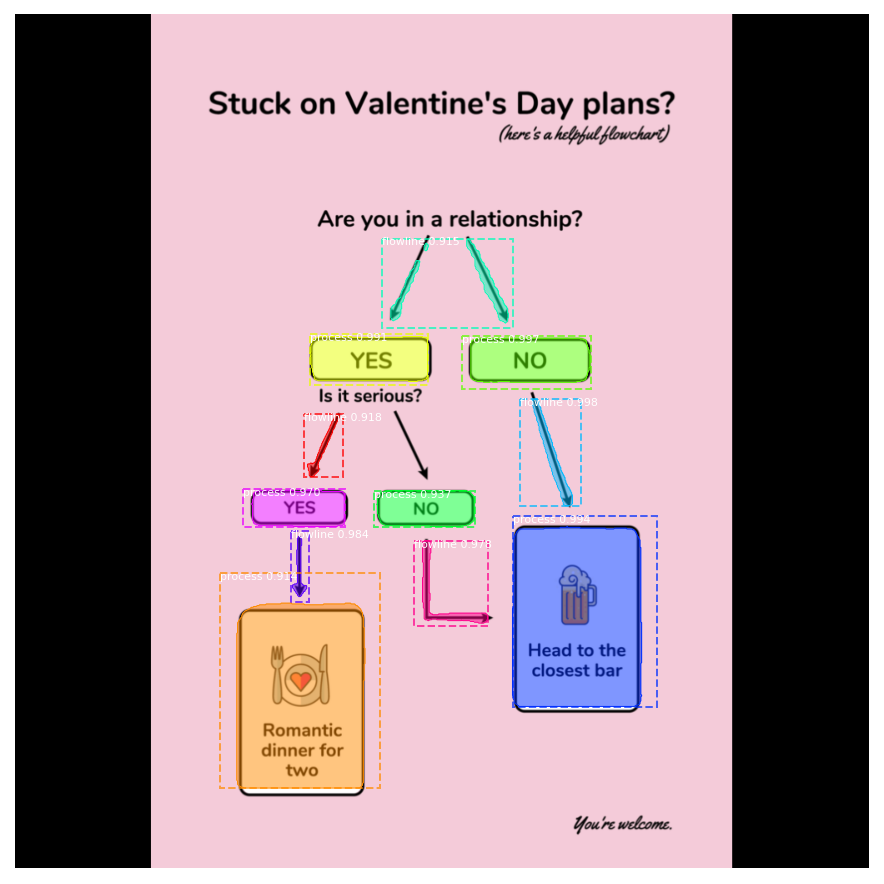

gt_class_id              shape: (14,)                 min:    2.00000  max:    5.00000  int32
gt_bbox                  shape: (14, 4)               min:  227.00000  max:  939.00000  int32
gt_mask                  shape: (1024, 1024, 14)      min:    0.00000  max:    1.00000  bool


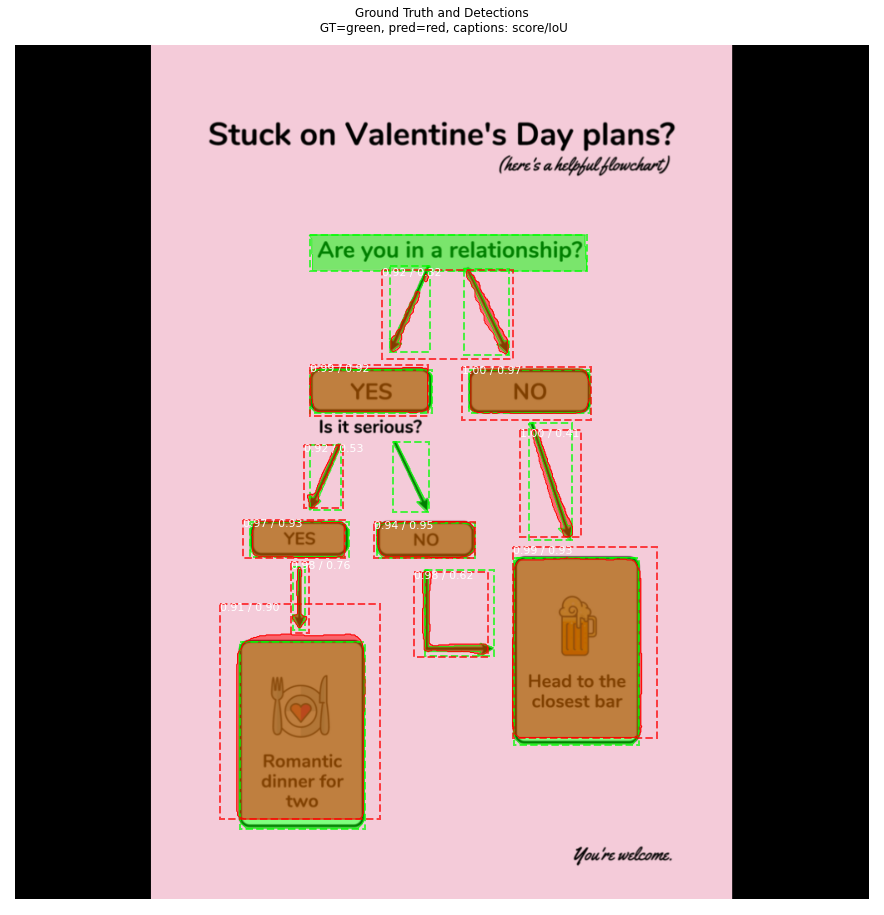

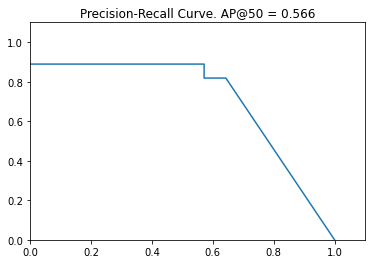

In [10]:
##Change from image to img_list where img_list==BATCH_SIZE (BS == IMAGES_PER_GPU * GPU_COUNT) to run on multiple GPUs
image_ids = random.choice(dataset.image_ids, config.BATCH_SIZE)
print(config.BATCH_SIZE)
images = []
for image_id in image_ids:
    ima, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    images.append(ima)
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect(images, verbose=1)
#masks = []
for i, im in enumerate(images):
    r = results[i]
    #masks.append(r['masks'])
    visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'])
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    visualize.display_differences(image=im, gt_box=gt_bbox, gt_class_id=gt_class_id, gt_mask=gt_mask, pred_box=r['rois'],
                                  pred_class_id=r['class_ids'], pred_score=r['scores'], pred_mask=r['masks'], class_names=dataset.class_names)

    mAP, precisions, recalls, overlaps = utils.compute_ap(gt_boxes=gt_bbox, gt_class_ids=gt_class_id, gt_masks=gt_mask,
                     pred_boxes=r['rois'], pred_class_ids=r['class_ids'], pred_scores=r['scores'], pred_masks=r['masks'])
    visualize.plot_precision_recall(AP=mAP, precisions=precisions, recalls=recalls)


In [11]:
# iterate through masks
r = results[0]
masks = r['masks']
class_ids = r['class_ids']


0
1
2
3
4
5
6
7
8
9


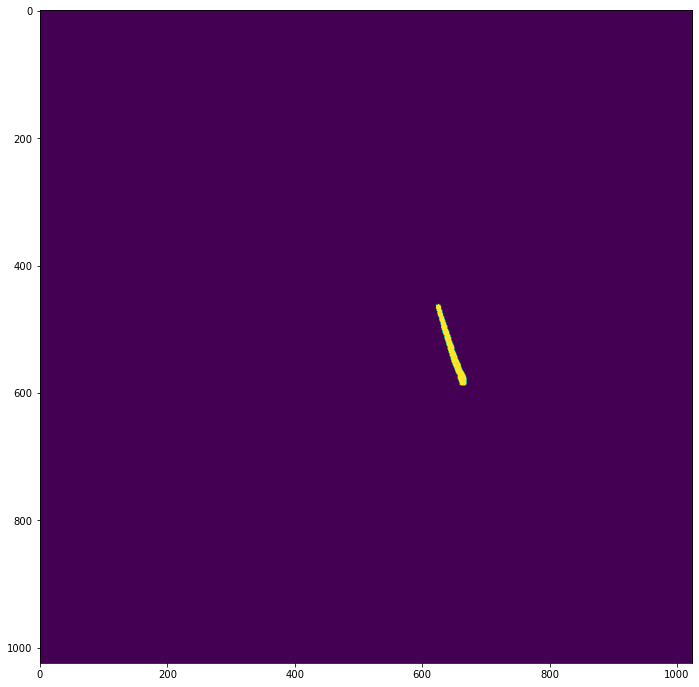

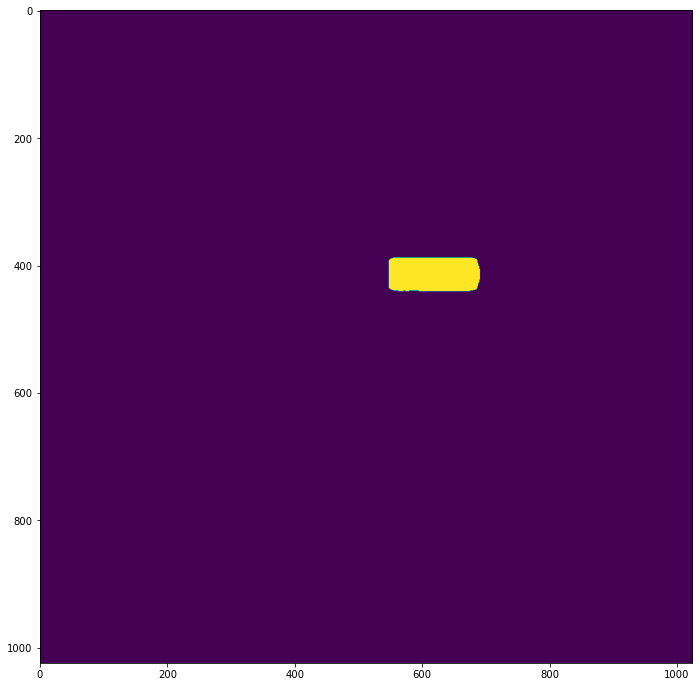

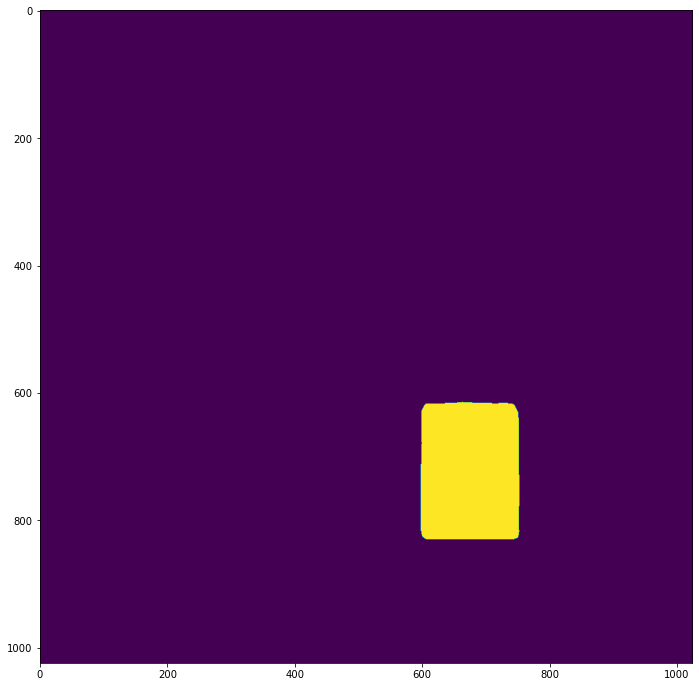

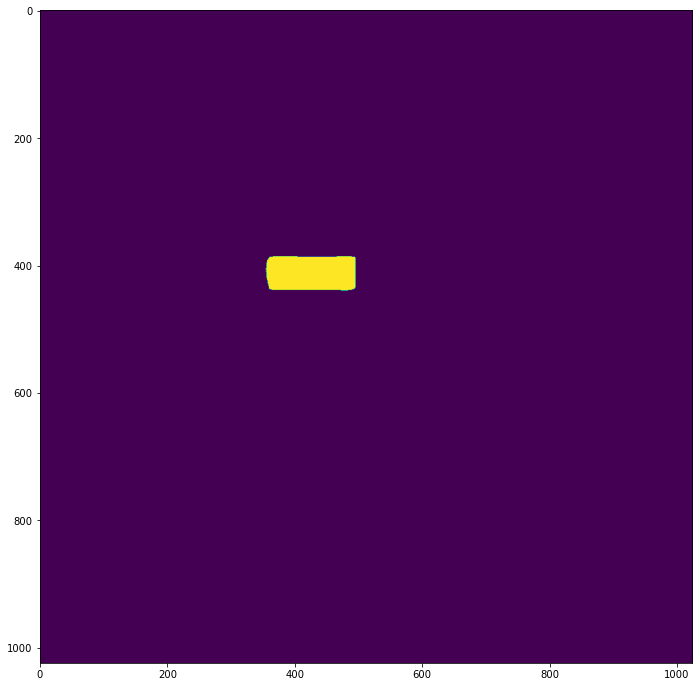

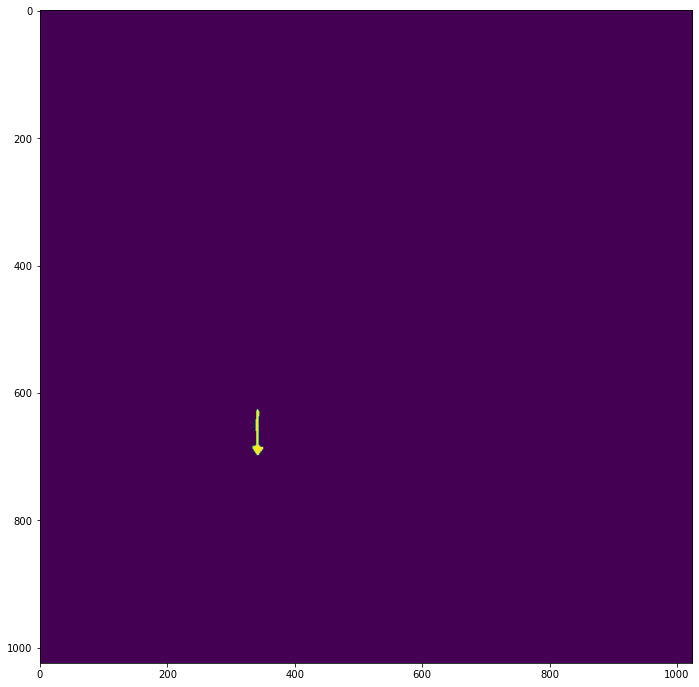

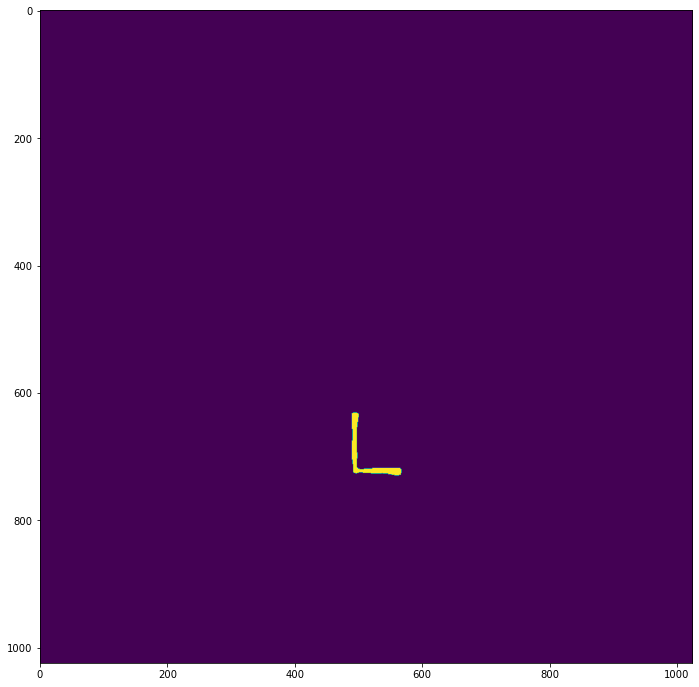

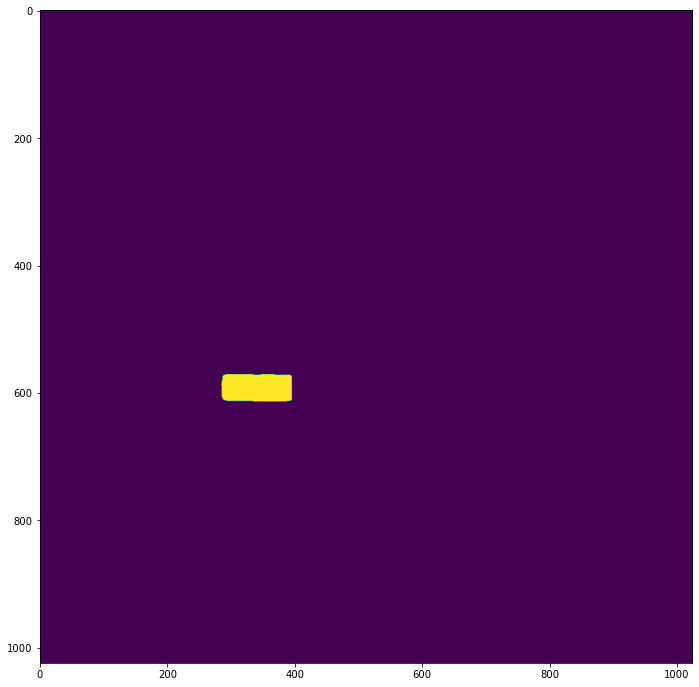

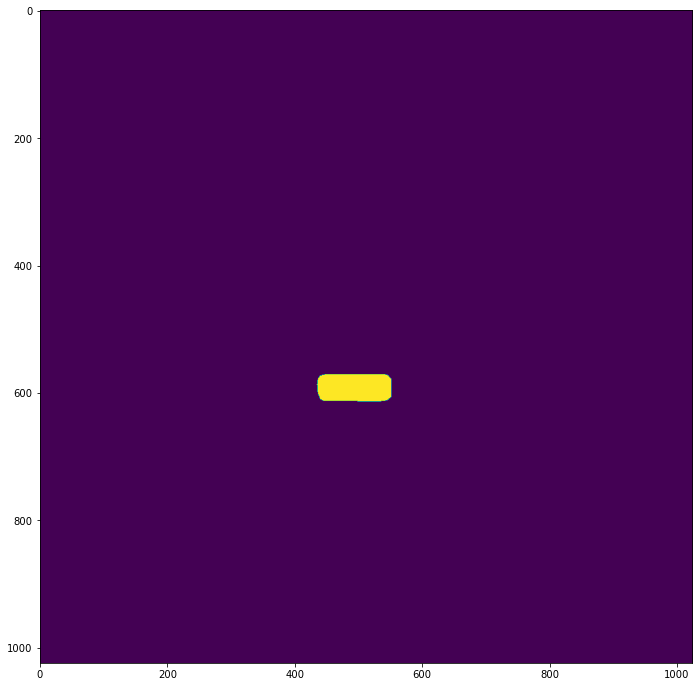

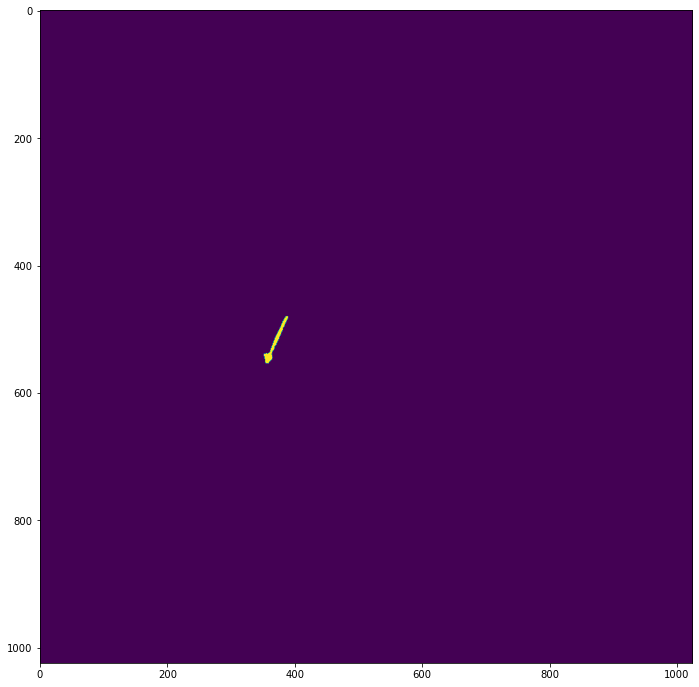

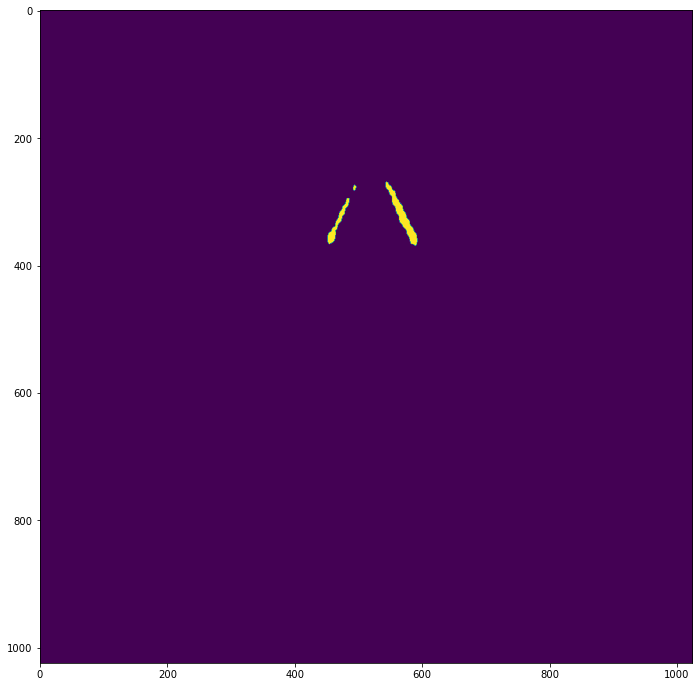

In [12]:
for i in range(0,masks.shape[2]-1):
    print(i)
    next_mask = masks[:, :, i]
    plt.figure(figsize=(12, 12))
    plt.imshow(next_mask)

In [13]:
def load_doc(filename_data_input):
    # open the file as read only
    file = open(filename_data_input, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


In [14]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x


# Function to encode a given image into a vector of size (2048, )
def encode(image_path):
    prepro_image = preprocess(image_path)  # preprocess the image
    fea_vec = model_new.predict(prepro_image)  # Get the encoding vector for the image
    # fea_vec = np.reshape(fea_vec, fea_vec.shape[1])  # reshape from (1, 2048) to (2048, )
    return fea_vec

In [15]:
with open("./wordtoix.pkl", "rb") as encoded_pickle:
    wordtoix = load(encoded_pickle)

with open("./ixtoword.pkl", "rb") as encoded_pickle:
    ixtoword = load(encoded_pickle)

max_length = 124 # TODO: get number dynamically
def greedy_search(photo):
    model = load_model('../../model_captioning_weights/model_30.h5')
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


def insert_new_line(text):
    with_nl = text.split('\\n')
    return with_nl


def load_test_descriptions(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    references = []
    pic_ids = []
    for pic_id in image_ids:
        pic_info = dataset.image_info[pic_id]
        pic_name= pic_info['id']
        pic_tokens = pic_name.split('.')
        pic_id = pic_tokens[0]
        pic_ids.append(pic_id)

    for id in pic_ids:
        for line in text.split('\n'):
            tokens = line.split()
            image_id, image_desc = tokens[0], tokens[1:]
            if image_id == id:
                references.append(image_desc)
    return references



(1, 2048)
Final Text:  if ( ! condition ) { \n process ; \n process ; \n } \n if ( ! condition ) { \n process ; \n process ; \n } \n terminal end ; \n
-----------------------
if ( ! condition ) { 
 process ; 
 process ; 
 } 
 if ( ! condition ) { 
 process ; 
 process ; 
 } 
 terminal end ; 

-----------------------


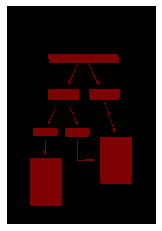

In [16]:
for image_id in image_ids:
    # masks, class_ids = dataset.load_mask(image_id)
    x = np.zeros((masks.shape[0], masks.shape[1]))
    plt.imshow(x, cmap=mpl.cm.bone)
    for i in range(0,masks.shape[2]):
        currentMask = masks[:,:,i]
        currentMask = np.ma.masked_where(currentMask == 0, currentMask)
        plt.imshow(currentMask, cmap=mpl.cm.jet_r, interpolation='nearest')
    # plt.show()
    info = dataset.image_info[image_id]
    image_name= info['id']
    image_path = '../../FlowchartDataMRCNN/TestingImages/' + image_name
    # plt.axis('off')
    # plt.savefig(image_name, bbox_inches='tight', pad_inches=0)

    model = InceptionV3(weights='imagenet')
    model_new = Model(model.input, model.layers[-2].output)
    encodingImg = encode(image_path)
    print(encodingImg.shape)
    final_text = greedy_search(encodingImg)
    print("Final Text: ", final_text)
    print('-----------------------')
    print('\n'.join(insert_new_line(final_text)))
    print('-----------------------')

In [17]:
# Testing Sorting Neural Net
class_ids_as_list = [class_ids]

#TODO: put maxlen from Neural net dynamically
x_test_symbols = tf.keras.preprocessing.sequence.pad_sequences(
    class_ids_as_list, maxlen=40, padding="post")
print(x_test_symbols)

[[5 5 5 5 5 5 5 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


In [18]:
x_test_pics = []
image_name = ''
for image_id in image_ids:
    info = dataset.image_info[image_id]
    image_name= info['id']
print(np.shape(images))
image_path = '../../FlowchartDataMRCNN/TestingImages/' + image_name
img = image.load_img(image_path, color_mode='grayscale', target_size=(250, 250))
print(np.shape(img))
x = image.img_to_array(img)
print(np.shape(x))
x_test_pics.append(x)

(1, 1024, 1024, 3)
(250, 250)
(250, 250, 1)


In [19]:
model = load_model('../../model_sorting_weights/model_weights.h5')
prediction = model.predict([np.asarray(x_test_symbols), np.asarray(x_test_pics)])
print(prediction)
print([np.asarray(x_test_symbols).reshape(40, )
       [np.abs(np.asarray(x_test_symbols).reshape(40, ) - i).argmin()] for i in list(prediction[0])])

[[ 2.7913463e+00  1.5386875e+00  2.7690115e+00  2.0392635e+00
   3.8627698e+00  1.5360129e+00  3.8376122e+00  1.7693405e+00
   3.8401697e+00  1.8741833e+00  3.5613818e+00  1.8127418e+00
   4.4862847e+00  1.6875496e+00  2.9444127e+00  1.2253352e+00
   2.2226095e+00  6.2500626e-01  1.2855178e+00  7.3705280e-01
  -3.2709122e-02  2.6566771e-01 -2.8920552e-01  6.2941188e-01
  -3.3594498e-01 -1.4707866e-01  1.1561792e-01  4.4934645e-02
   7.9667673e-02 -4.2718402e-03 -9.8715365e-02  2.4990179e-02
  -3.5299957e-03 -1.1309823e-02  3.9287049e-01 -8.7461993e-02
  -8.0962695e-02  6.1191492e-02  1.7289194e-01 -2.1577935e-01]]
[2, 2, 2, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
